# 2.4 Temporal Fusion Transformer Modell zur Ex Ante Prognose

### Pakete einladen

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Einladen der benötigten Module

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import os

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from sklearn.model_selection import ParameterGrid
os.environ["KERAS_BACKEND"] = "tensorflow"
from tensorboardX import SummaryWriter
import tensorflow as tf
import tensorboard
from tensorboard.plugins.hparams import api as hp
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Löschen alter Metadaten und damit Freigabe bislang belegter ports 
from tensorboard import manager
tensorboard_dir = manager._get_info_dir()
for instance in os.listdir(tensorboard_dir):
    os.remove(os.path.join(tensorboard_dir,instance))

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

import torch

False


### Vorbereitung der Daten

In [ ]:
#Daten einladen
data_Preise = pd.read_excel(r"../data/Daten_Preise.xlsx", sheet_name='Tabelle1', skiprows=1, index_col=0)
data_Preise = data_Preise.resample('h').ffill()
data_Preise.index = pd.to_datetime(data_Preise.index, format= "%Y-%m-%d %H:%M:%S")

data_Sonstige = pd.read_excel(r"../data/Daten_sonstige_h.xlsx", sheet_name='Tabelle1', skiprows=1, index_col=0)
data_Sonstige.index = pd.to_datetime(data_Sonstige.index, format= "%d.%m.%Y %H:%M")

# Index in ein einheitliches Format übertragen
data_Preise.index = data_Preise.index.strftime("%Y-%m-%d %H:%M:%S")
index1 = data_Preise.index
data_Sonstige.index = data_Sonstige.index.strftime("%Y-%m-%d %H:%M:%S")
index2 = data_Sonstige.index

#Daten in einem DataFrame zusammenfügen
data_roh = pd.merge(data_Sonstige, data_Preise, left_index=True, right_index=True, how='inner')
data_roh.index = pd.to_datetime(data_roh.index)
data_roh["Day-of-year"] = data_roh.index.dayofyear
#data_roh

,Wochentag,Prognose Wind Offshore [MWh],Prognose Wind Onshore [MWh],Prognose Photovoltaik [MWh],Prognose Sonstige [MWh],Prognose Gesamt (Netzlast) [MWh],Prognose Residuallast [MWh],Biomasse [MWh],Wasserkraft [MWh],Wind Offshore [MWh],...,Day-ahead Auktion (volumengewichtet) [€/MWh],Volumen (+) [MWh],Volumen (-) [MWh],Preis [€/MWh],Kohle [€/t],Gas [€/MWh],CO2 [€/t],BIP,Verbraucherpreisindex,Day-of-year
ContractBegin,,,,,,,,,,,,,,,,,,,,,
2015-01-05 00:00:00,2,551.75,10009.75,0.0,47097.50,43176.00,32614.50,4064.00,1680.25,473.75,...,17.93,0,-844,-37.56,64.7,7.24,20.354,100.0,100.0,5
2015-01-05 01:00:00,2,547.75,10287.75,0.0,44789.50,41597.75,30762.25,4069.25,1676.50,464.75,...,15.17,0,-589,-15.97,64.7,7.24,20.354,100.0,100.0,5
2015-01-05 02:00:00,2,542.50,10418.50,0.0,43457.00,40421.75,29460.75,4068.50,1661.50,461.50,...,16.38,0,-625,-15.35,64.7,7.24,20.354,100.0,100.0,5
2015-01-05 03:00:00,2,533.75,10601.75,0.0,43335.50,40404.25,29268.75,4067.00,1644.00,450.25,...,17.38,0,-494,-14.54,64.7,7.24,20.354,100.0,100.0,5
2015-01-05 04:00:00,2,521.75,10809.75,0.0,44479.50,41348.25,30016.75,4052.00,1632.00,453.50,...,16.38,0,-1294,-61.14,64.7,7.24,20.354,100.0,100.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-28 20:00:00,5,1230.00,5514.75,252.0,45566.25,58524.25,51527.50,4814.00,1441.25,1352.00,...,268.91,414,0,412.93,286.5,85.04,85.040,108.2,116.6,118
2022-04-28 21:00:00,5,1133.75,6178.00,0.0,43957.25,56366.25,49054.50,4778.75,1412.75,1362.50,...,253.56,136,-19,314.46,286.5,85.04,85.040,108.2,116.6,118
2022-04-28 22:00:00,5,1017.25,6537.00,0.0,42921.75,53424.75,45870.50,4665.75,1409.00,1200.00,...,222.78,555,0,304.52,286.5,85.04,85.040,108.2,116.6,118


In [4]:
#Dataframe als Backup umbenennen
data_roh
df_cleaned = data_roh

Index(['Wochentag', 'Prognose Wind Offshore [MWh] ',
       'Prognose Wind Onshore [MWh]', 'Prognose Photovoltaik [MWh]',
       'Prognose Sonstige [MWh]', ' Prognose Gesamt (Netzlast) [MWh]',
       'Prognose Residuallast [MWh]', 'Biomasse [MWh]', 'Wasserkraft [MWh]',
       'Wind Offshore [MWh]', 'Wind Onshore [MWh]', 'Photovoltaik [MWh]',
       'Sonstige Erneuerbare [MWh]', 'Kernenergie [MWh]', 'Braunkohle [MWh]',
       'Steinkohle [MWh]', 'Erdgas [MWh]', 'Erzeugung Pumpspeicher [MWh]',
       'Sonstige Konventionelle [MWh]', 'Gesamt (Netzlast) [MWh]',
       'Residuallast [MWh]', 'Pumpspeicher [MWh]', 'Nettoexport [MWh]',
       'Day-ahead Auktion (volumengewichtet) [€/MWh]', 'Volumen (+) [MWh]',
       'Volumen (-) [MWh]', 'Preis [€/MWh]', 'Kohle [€/t]', 'Gas [€/MWh]',
       'CO2 [€/t]', 'BIP ', 'Verbraucherpreisindex', 'Day-of-year', 'diff'],
      dtype='object')


## Feature Engineering

In [5]:
#Zeitliche Einflüsse
#Tag des Jahres
df_cleaned["Day-of-year"] = df_cleaned.index.dayofyear
#Monat
df_cleaned["Monat"] = df_cleaned.index.month
# Stunde des Tages
df_cleaned["Stunde"] = df_cleaned.index.hour
#Feiertage
de_holidays = holidays.Germany(years=range(2015, 2022))
df_cleaned['Feiertag'] = df_cleaned.index.isin(de_holidays).astype(int)


#Berücksichtigung Ausgleichsenergie spez. Kosten 
df_cleaned["Ausgleichsenergie [€]"] = (df_cleaned["Volumen (+) [MWh]"]+df_cleaned["Volumen (-) [MWh]"])*df_cleaned["Preis [€/MWh]"] #Überprüft nicht geeignet. Kein Zusammenhang mit großer Auswirkung erkennbar


#Kraftwerke mit Preisen
df_cleaned['Summe_CO2'] = df_cleaned['Braunkohle [MWh]']* 1.188 +df_cleaned['Steinkohle [MWh]']* 0.95 +df_cleaned['Erdgas [MWh]']*0.4
df_cleaned['Summe_Kohle'] = df_cleaned['Braunkohle [MWh]']*0.2398 +df_cleaned['Steinkohle [MWh]']*0.1228
df_cleaned['Kraftwerke_CO2'] = (df_cleaned['Braunkohle [MWh]']* 1.188 +df_cleaned['Steinkohle [MWh]']* 0.95 +df_cleaned['Erdgas [MWh]']*0.4)*df_cleaned['CO2 [€/t]']
df_cleaned['Kraftwerke_Kohle'] = (df_cleaned['Braunkohle [MWh]']*0.2398 +df_cleaned['Steinkohle [MWh]']*0.1228 )*df_cleaned['Kohle [€/t]']
df_cleaned['Kraftwerke_Gas'] = df_cleaned['Erdgas [MWh]']*df_cleaned['Gas [€/MWh]']
df_cleaned['Kosten_Erdgas'] = (df_cleaned['Erdgas [MWh]']* df_cleaned['Gas [€/MWh]'])+ (df_cleaned['Erdgas [MWh]']*0.4*df_cleaned['CO2 [€/t]'])
df_cleaned['Kosten_Braunkohle'] = (df_cleaned['Braunkohle [MWh]']*0.2398*df_cleaned['Kohle [€/t]'])+ (df_cleaned['Braunkohle [MWh]']*1.188*df_cleaned['CO2 [€/t]'])
df_cleaned['Kosten_Steinkohle'] = (df_cleaned['Steinkohle [MWh]']*0.1228*df_cleaned['Kohle [€/t]'])+ (df_cleaned['Steinkohle [MWh]']*0.95*df_cleaned['CO2 [€/t]'])
df_cleaned['Kraftwerke_Fossil'] = df_cleaned['Kraftwerke_Gas']*df_cleaned['Kraftwerke_Kohle']*df_cleaned['Kraftwerke_CO2']
#Quellen-CO2: 
#Braunkohle: hhttps://www.bund-nrw.de/braunkohle/hintergruende-und-publikationen/braunkohlenkraftwerke-contra-klimaschutz/
#Steinkohle: https://www.brisant.de/braunkohle-umwelt-100.html
#Erdgas: https://www.ise.fraunhofer.de/de/presse-und-medien/news/2019/33-prozent-weniger-co2-emissionen-durch-brennstoffwechsel-von-kohle-auf-gas.html

#Quellen-Kohle:
#Braunkohle: https://agrarplus.at/heizwerte-aequivalente.html
#Steinkohle: https://www.unitjuggler.com/energy-umwandeln-von-MWh-nach-tSKE.html


# Anteil Erneuerbarer
df_cleaned['Summe_Ern']= df_cleaned[['Wind Offshore [MWh]', 'Wind Onshore [MWh]', 'Photovoltaik [MWh]','Biomasse [MWh]', 'Sonstige Erneuerbare [MWh]','Wasserkraft [MWh]',]].sum(axis=1)
df_cleaned['Anteil Erneuerbarer'] = df_cleaned['Summe_Ern'] / (df_cleaned['Gesamt (Netzlast) [MWh]']) * 100
df_cleaned['Anteil_PV'] = df_cleaned['Photovoltaik [MWh]']/df_cleaned['Summe_Ern']
df_cleaned['Anteil_Offshore'] = df_cleaned['Wind Offshore [MWh]']/df_cleaned['Summe_Ern']

df_cleaned['Prognose_Summe_Ern']= df_cleaned[['Prognose Wind Offshore [MWh] ', 'Prognose Wind Onshore [MWh]', 'Prognose Photovoltaik [MWh]']].sum(axis=1)
prog_proz_ern = df_cleaned['Prognose_Summe_Ern'] / (df_cleaned[' Prognose Gesamt (Netzlast) [MWh]']) * 100
df_cleaned['Prognose Anteil Erneuerbarer'] = prog_proz_ern

# Überschuss Erzeugung
summe_erzeugung = df_cleaned[['Biomasse [MWh]', 'Wasserkraft [MWh]',
       'Wind Offshore [MWh]', 'Wind Onshore [MWh]', 'Photovoltaik [MWh]',
       'Sonstige Erneuerbare [MWh]', 'Kernenergie [MWh]', 'Braunkohle [MWh]',
       'Steinkohle [MWh]', 'Erdgas [MWh]', 'Erzeugung Pumpspeicher [MWh]',
       'Sonstige Konventionelle [MWh]']].sum(axis=1)
df_cleaned['Überschuss'] = summe_erzeugung - df_cleaned['Gesamt (Netzlast) [MWh]']


# Abweichung Prognose Residuallast
df_cleaned['Abweichung_Prognose_Residuallast'] = (df_cleaned['Residuallast [MWh]'] - df_cleaned['Prognose Residuallast [MWh]'])


#mögliche Interaktionen zwischen Features
df_cleaned['Int_Gas'] = df_cleaned['Gas [€/MWh]']*df_cleaned['Gesamt (Netzlast) [MWh]']
df_cleaned['Int_Gas_Resi'] = df_cleaned['Gas [€/MWh]']*df_cleaned['Residuallast [MWh]']
df_cleaned['Int_CO2_Erz'] = summe_erzeugung*df_cleaned['CO2 [€/t]']
df_cleaned['Int_CO2_Kohle'] = df_cleaned['Braunkohle [MWh]']* 1.188 +df_cleaned['Steinkohle [MWh]']* 0.95*df_cleaned['CO2 [€/t]']
df_cleaned['Int_Ern_Foss'] = df_cleaned['Anteil Erneuerbarer'] * df_cleaned['Erdgas [MWh]']*df_cleaned['Steinkohle [MWh]']*df_cleaned['Braunkohle [MWh]']
df_cleaned['Int_Preise'] = df_cleaned['Kraftwerke_CO2']*df_cleaned['Kraftwerke_Kohle']*df_cleaned['Kraftwerke_Gas']
df_cleaned['Int_Pumpspeicher'] = df_cleaned['Pumpspeicher [MWh]']/df_cleaned['Kraftwerke_Fossil']

# Versuch Einbau der Merit-Order als Feature. leider erfolglos
merit_order = ['Wind Offshore [MWh]', 'Wind Onshore [MWh]', 'Photovoltaik [MWh]', 'Wasserkraft [MWh]','Biomasse [MWh]',
               'Sonstige Erneuerbare [MWh]', 'Kernenergie [MWh]', 'Braunkohle [MWh]', 'Steinkohle [MWh]', 'Erdgas [MWh]',
               'Erzeugung Pumpspeicher [MWh]', 'Sonstige Konventionelle [MWh]']

df_order = df_cleaned[merit_order]
df_cumsum = df_order.cumsum(axis=1)
print(df_cumsum)
gesamtlast_serie = df_cleaned['Gesamt (Netzlast) [MWh]']

def finde_lastdeckung(row, gesamtlast):
    for kraftwerk, kum_erz in row.items():
        if kum_erz >= gesamtlast:
            return kraftwerk, kum_erz
        return None, None

#df_cleaned['Deckendes Kraftwerk'], df_cleaned['Erzeugung bei Deckung'] = zip(*df_cumsum.apply(lambda row: finde_lastdeckung(row, gesamtlast_serie[row.name]), axis = 1))
#print(df_cleaned[['Deckendes Kraftwerk', 'Erzeugung bei Deckung']])

#Standardabweichung
df_cleaned['Std_Gas'] = df_cleaned['Gas [€/MWh]'].rolling(window=24).std()
df_cleaned['Std_Kohle'] = df_cleaned['Kohle [€/t]'].rolling(window=24).std()
df_cleaned['Std_CO2'] = df_cleaned['CO2 [€/t]'].rolling(window=24).std()
df_cleaned['Std_Erneuerbare_Tag'] = df_cleaned['Summe_Ern'].rolling(window=24).std()
df_cleaned['Std_Prognose'] = df_cleaned['Abweichung_Prognose_Residuallast'].rolling(window=24).std()

#Gleitender Durchschnitt Preise
#df_cleaned['Moving_Average_Gas'] = df_cleaned['Gas [€/MWh]'].rolling(window=2500).mean()
#df_cleaned['Moving_Average_Kohle'] = df_cleaned['Kohle [€/t]'].rolling(window=2500).mean()
#df_cleaned['Moving_Average_CO2'] = df_cleaned['CO2 [€/t]'].rolling(window=2500).mean()

df_cleaned = df_cleaned.dropna()
df_cleaned = df_cleaned.loc[:'2021-05-01']

#Spalten löschen
df_cleaned = df_cleaned.drop(['Volumen (+) [MWh]', 'Volumen (-) [MWh]', 'Preis [€/MWh]'], axis=1)


Index(['Wochentag', 'Prognose Wind Offshore [MWh] ',
       'Prognose Wind Onshore [MWh]', 'Prognose Photovoltaik [MWh]',
       'Prognose Sonstige [MWh]', ' Prognose Gesamt (Netzlast) [MWh]',
       'Prognose Residuallast [MWh]', 'Biomasse [MWh]', 'Wasserkraft [MWh]',
       'Wind Offshore [MWh]', 'Wind Onshore [MWh]', 'Photovoltaik [MWh]',
       'Sonstige Erneuerbare [MWh]', 'Kernenergie [MWh]', 'Braunkohle [MWh]',
       'Steinkohle [MWh]', 'Erdgas [MWh]', 'Erzeugung Pumpspeicher [MWh]',
       'Sonstige Konventionelle [MWh]', 'Gesamt (Netzlast) [MWh]',
       'Residuallast [MWh]', 'Pumpspeicher [MWh]', 'Nettoexport [MWh]',
       'Day-ahead Auktion (volumengewichtet) [€/MWh]', 'Volumen (+) [MWh]',
       'Volumen (-) [MWh]', 'Preis [€/MWh]', 'Kohle [€/t]', 'Gas [€/MWh]',
       'CO2 [€/t]', 'BIP ', 'Verbraucherpreisindex', 'Day-of-year', 'diff',
       'Stunde', 'Ausgleichsenergie [€]', 'Summe_CO2', 'Summe_Kohle',
       'Kraftwerke_CO2', 'Kraftwerke_Kohle', 'Kraftwerke_Gas', 'Kos

In [6]:
# Definieren von Konstanten
num_samples = 200

figsize = (14, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

Methode zur Erstellung der transformierten Zeitserien

In [7]:
def transform_ts(series,after):
    train, val = series.split_after(after)
    transformer = Scaler()
    train_transformed = transformer.fit_transform(train)
    val_transformed = transformer.transform(val)
    series_transformed = transformer.transform(series)
    return train,val,transformer,train_transformed,val_transformed,series_transformed

In [8]:
# training cutoff
training_cutoff = 0.7

 Targets

In [9]:
# Traget-Series definieren und splitten
df_cleaned_test = df_cleaned[~df_cleaned.index.duplicated(keep='first')]
target_series = TimeSeries.from_dataframe(df_cleaned_test.loc[:'2021-05-01',['Day-ahead Auktion (volumengewichtet) [€/MWh]']], freq='1h', fillna_value=0)
train,val,target_transformer,target_train_transformed,target_val_transformed,target_series_transformed=\
                                   transform_ts(target_series,training_cutoff)


0


past_covariates

In [10]:
# past_covariates definieren und splitten
use_past_covariates = True
past_covariates = TimeSeries.from_dataframe(df_cleaned_test.loc[['Stunde', 'Wochentag', 'Day-of-year', 'Monat', 'Kraftwerke_Kohle', 'Kraftwerke_Gas', 'Kraftwerke_CO2',
                       'Ausgleichsenergie [€]', 'Anteil Erneuerbarer', 'Überschuss','Int_Pumpspeicher', 'Nettoexport [MWh]',
                       'Residuallast [MWh]', 'Abweichung_Prognose_Residuallast', 'Int_Gas_Resi', 'Temperatur',
                       'Kernenergie [MWh]','Erdgas [MWh]', 'Braunkohle [MWh]', 'Steinkohle [MWh]','Wind Offshore [MWh]', 
                        'Wind Onshore [MWh]', 'Photovoltaik [MWh]' ,'Biomasse [MWh]', 
                       'Wasserkraft [MWh]','Sonstige Erneuerbare [MWh]', 'Erzeugung Pumpspeicher [MWh]', 'Feiertag']], freq='1h', fillna_value=0)
_,_,past_covariates_transformer,past_covariates_train_transformed,past_covariates_val_transformed,past_covariates_series_transformed=\
                                   transform_ts(past_covariates,training_cutoff)

future_covariates

In [11]:
# future_covariates definieren und splitten
# in diesem Fall sind nur die Prognosen in der Zukunft bekannt
use_future_covariates = True
future_covariates = TimeSeries.from_dataframe(df_cleaned_test.loc[['Day-of-year', 'Stunde', 'Wochentag', 'Prognose Wind Offshore [MWh] ',
            'Prognose Wind Onshore [MWh]', 'Prognose Photovoltaik [MWh]', ' Prognose Gesamt (Netzlast) [MWh]',
            'Prognose Residuallast [MWh]']], freq='1h', fillna_value=0)
_,_,future_covariates_transformer,future_covariates_train_transformed,future_covariates_val_transformed,future_covariates_series_transformed=\
                                   transform_ts(future_covariates,training_cutoff)    

In [63]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, series=target_train_transformed[:-14], past_covariates=past_covariates_series_transformed, future_covariates=future_covariates_series_transformed, num_samples=num_samples)
    for i in range(1):
        fig,ax = plt.subplots(nrows = 1,ncols=1,figsize=figsize)
        comp = pred_series.univariate_component(i)

        actual_series.univariate_component(i)[comp.end_time()-(1.2*n)*comp.freq: comp.end_time()].plot(label="actual")
        # plot prediction with quantile ranges
        comp.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer, alpha=0.7)
        comp.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner, alpha=0.7)
        comp.plot(low_quantile=0.5, high_quantile=0.5, central_quantile=0.5, label='50%-Quantil', alpha=0.7)
        plt.title("MAPE: {:.2f}%".format(mape(val_series.univariate_component(i), pred_series.univariate_component(i))))
        plt.legend()
        plt.show()
    return pred_series

### Modell erstellen

In [27]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 24
forecast_horizon = 24
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=128,
    lstm_layers=2,
    num_attention_heads=4,
    dropout=0.4,
    batch_size=1500,
    n_epochs=40,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),
    random_state=42,
    pl_trainer_kwargs={
      "accelerator": "cpu"
    },
)

Training: |          | 0/? [00:00<?, ?it/s]

hidden_size: 32, lstm_layers: 1, num_attention_heads: 4


Predicting: |          | 0/? [00:00<?, ?it/s]

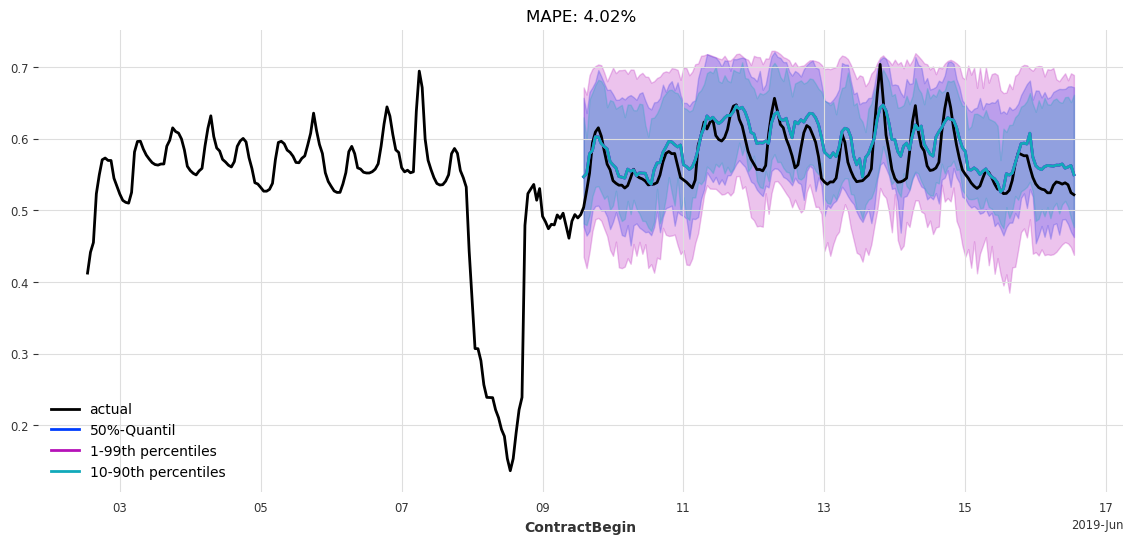

Training: |          | 0/? [00:00<?, ?it/s]

hidden_size: 32, lstm_layers: 1, num_attention_heads: 8


Predicting: |          | 0/? [00:00<?, ?it/s]

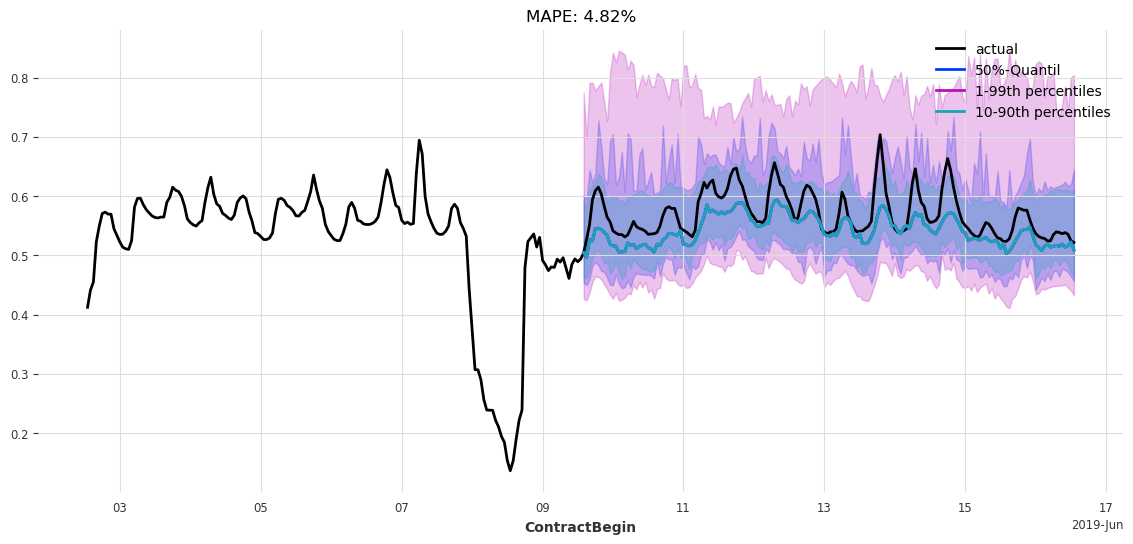

Training: |          | 0/? [00:00<?, ?it/s]

hidden_size: 32, lstm_layers: 2, num_attention_heads: 4


Predicting: |          | 0/? [00:00<?, ?it/s]

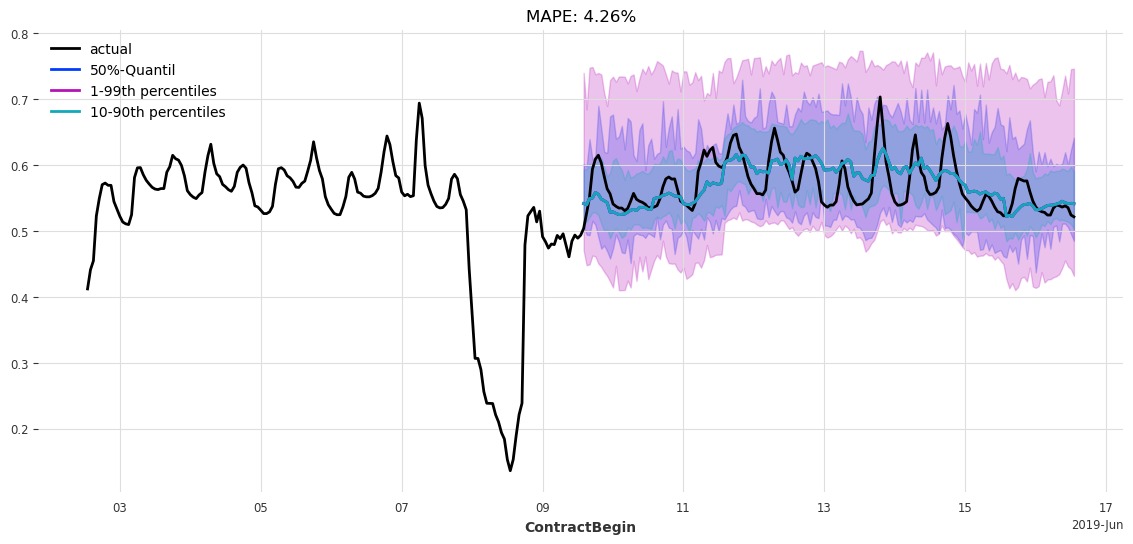

Training: |          | 0/? [00:00<?, ?it/s]

hidden_size: 32, lstm_layers: 2, num_attention_heads: 8


Predicting: |          | 0/? [00:00<?, ?it/s]

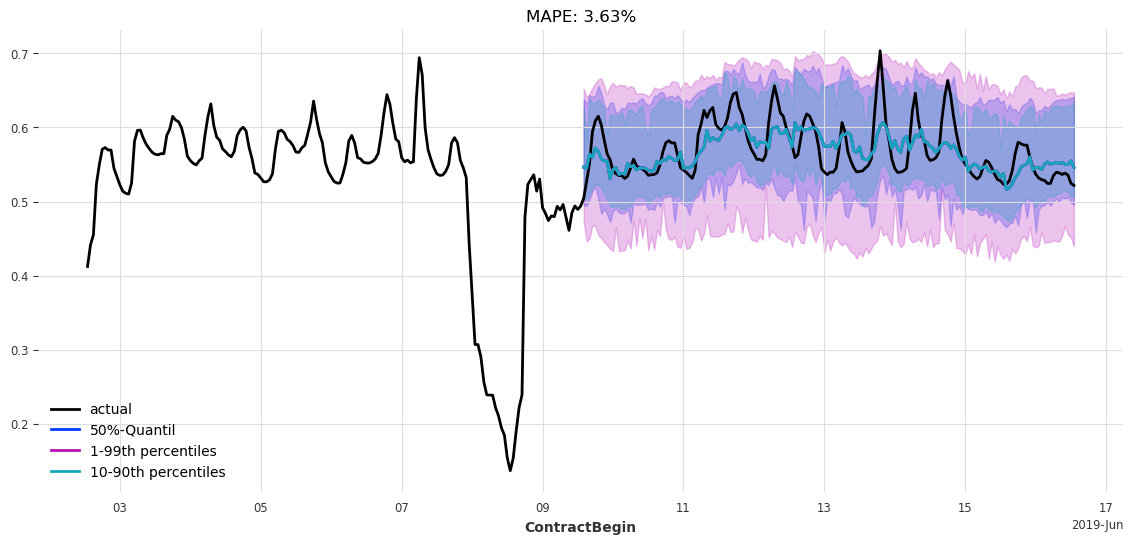

Training: |          | 0/? [00:00<?, ?it/s]

hidden_size: 64, lstm_layers: 1, num_attention_heads: 4


Predicting: |          | 0/? [00:00<?, ?it/s]

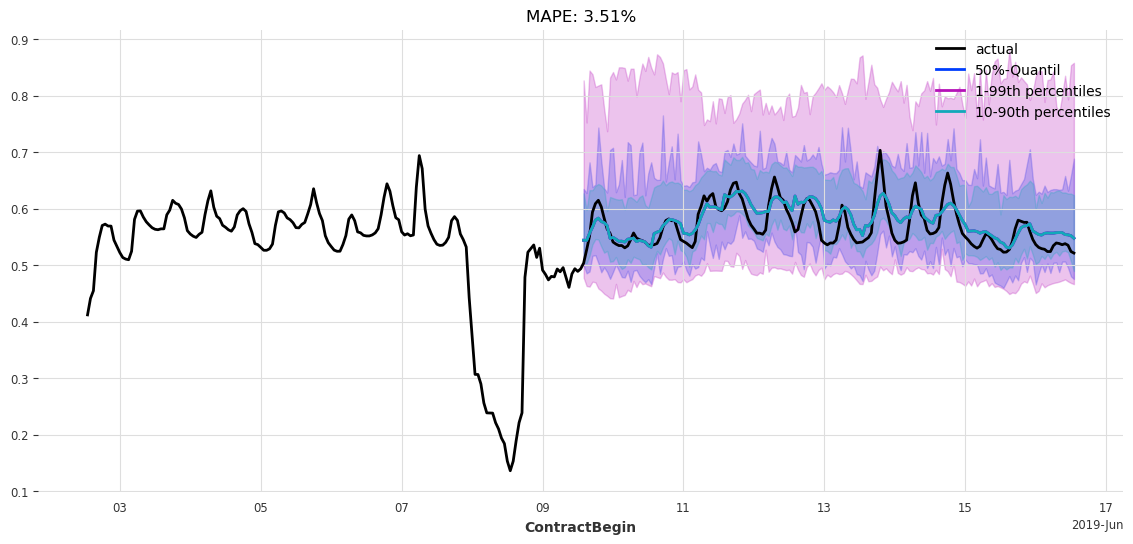

Training: |          | 0/? [00:00<?, ?it/s]

hidden_size: 64, lstm_layers: 1, num_attention_heads: 8


Predicting: |          | 0/? [00:00<?, ?it/s]

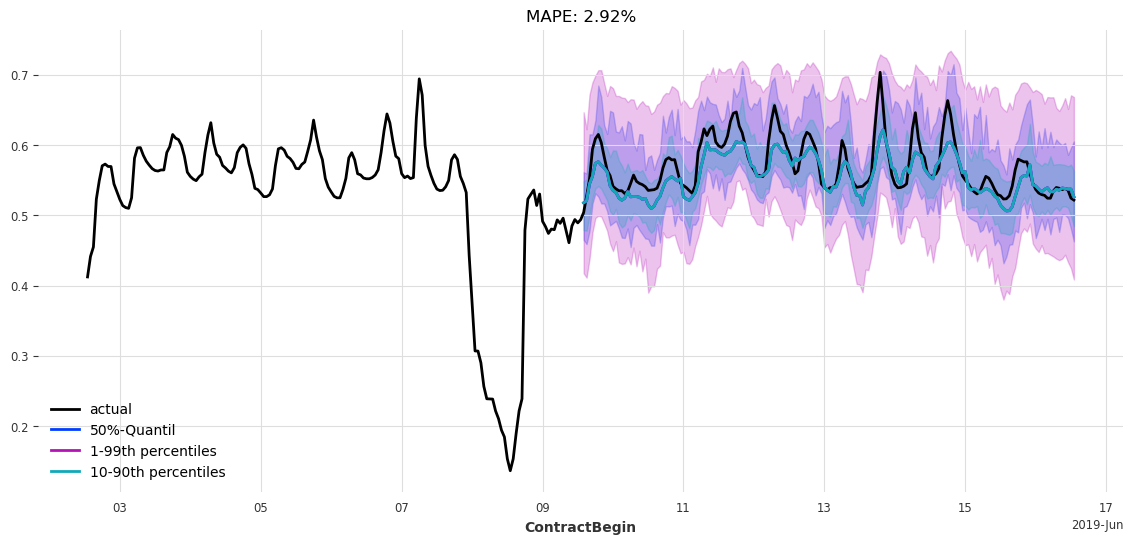

Training: |          | 0/? [00:00<?, ?it/s]

hidden_size: 64, lstm_layers: 2, num_attention_heads: 4


Predicting: |          | 0/? [00:00<?, ?it/s]

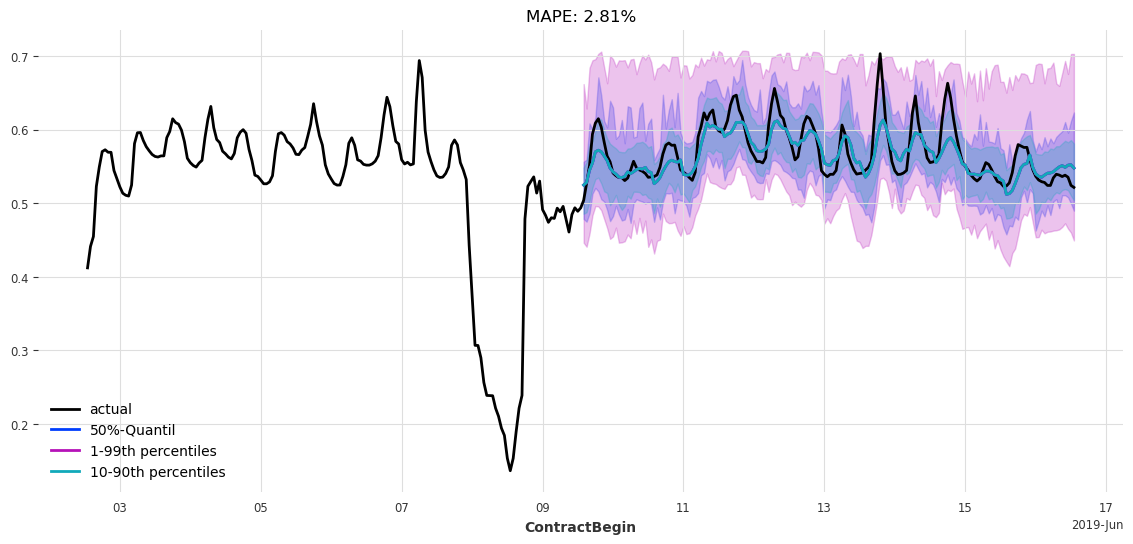

Training: |          | 0/? [00:00<?, ?it/s]

hidden_size: 64, lstm_layers: 2, num_attention_heads: 8


Predicting: |          | 0/? [00:00<?, ?it/s]

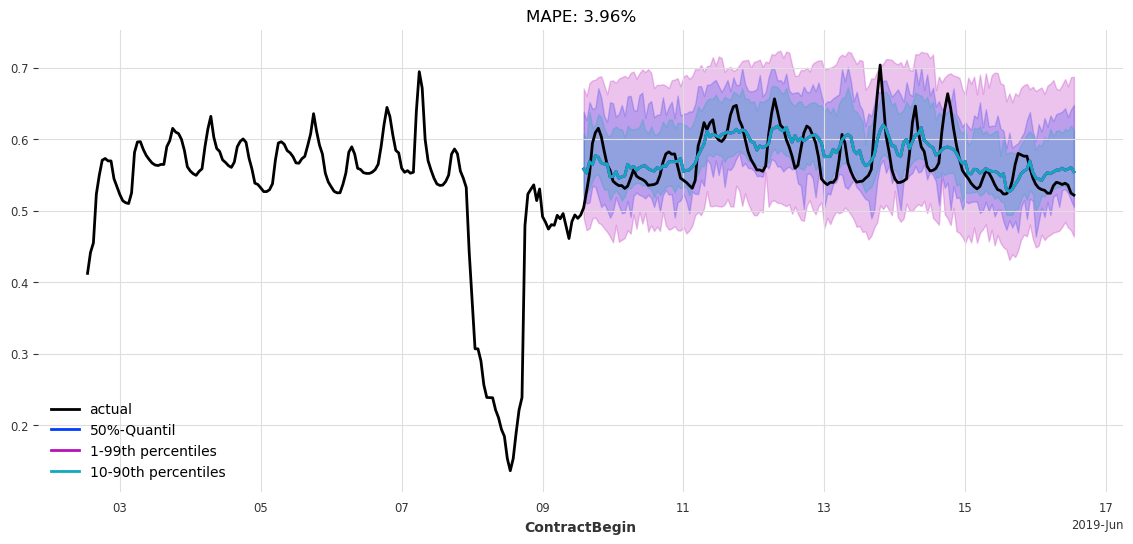

Training: |          | 0/? [00:00<?, ?it/s]

hidden_size: 128, lstm_layers: 1, num_attention_heads: 4


Predicting: |          | 0/? [00:00<?, ?it/s]

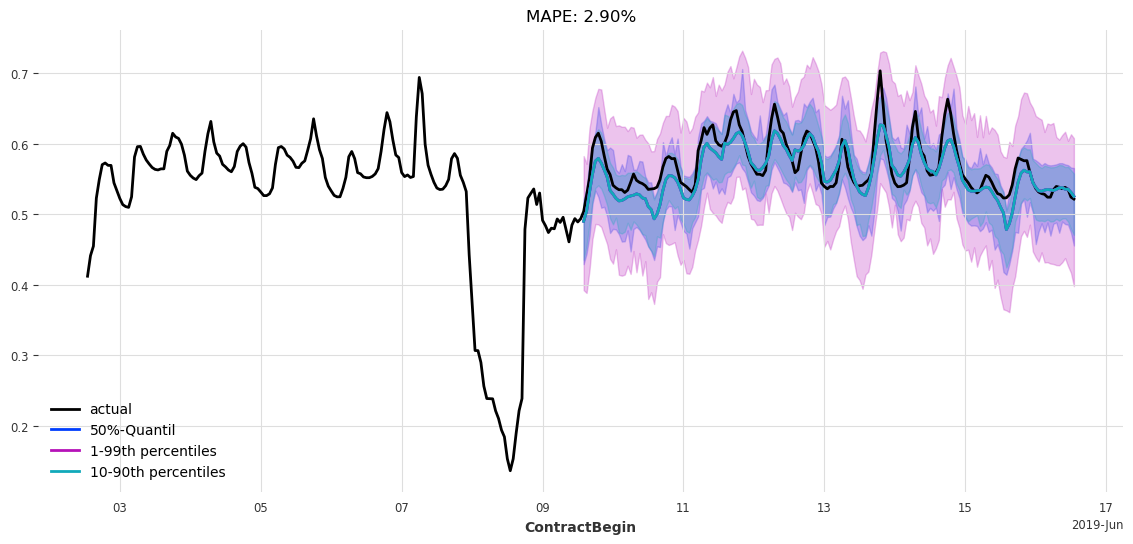

Training: |          | 0/? [00:00<?, ?it/s]

hidden_size: 128, lstm_layers: 1, num_attention_heads: 8


Predicting: |          | 0/? [00:00<?, ?it/s]

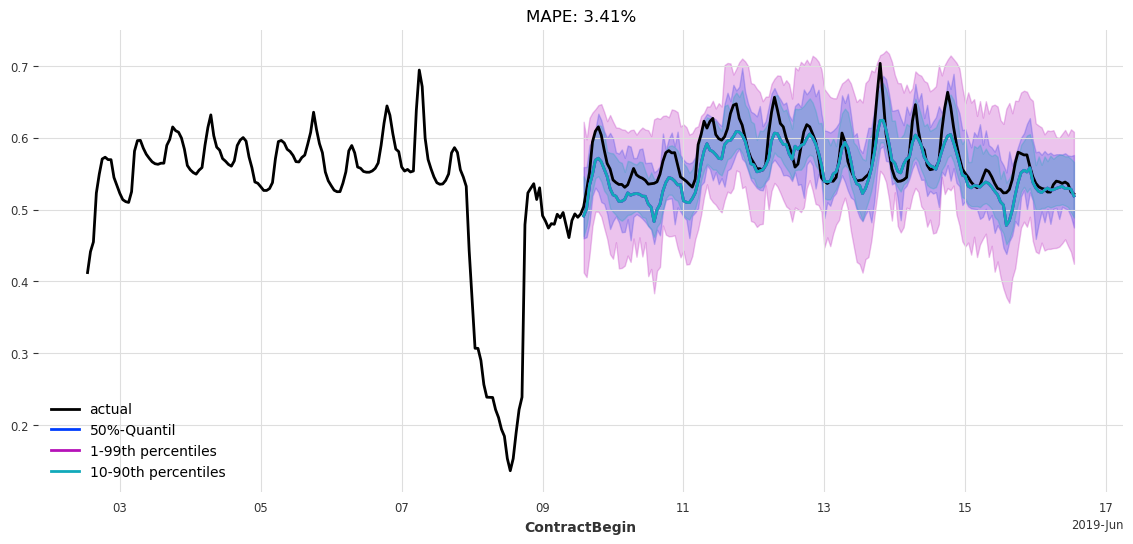

Training: |          | 0/? [00:00<?, ?it/s]

hidden_size: 128, lstm_layers: 2, num_attention_heads: 4


Predicting: |          | 0/? [00:00<?, ?it/s]

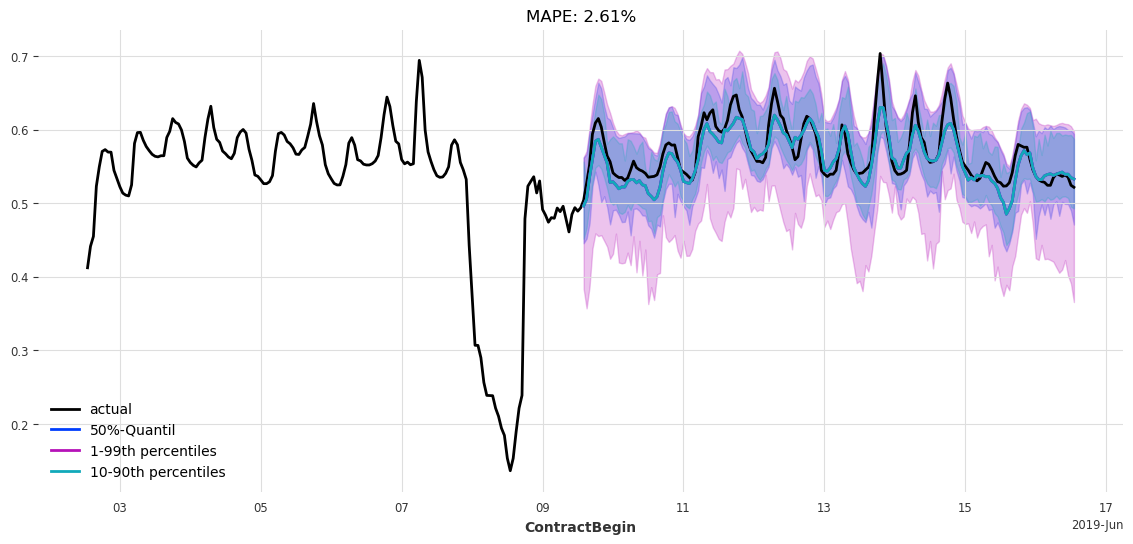

Training: |          | 0/? [00:00<?, ?it/s]

hidden_size: 128, lstm_layers: 2, num_attention_heads: 8


Predicting: |          | 0/? [00:00<?, ?it/s]

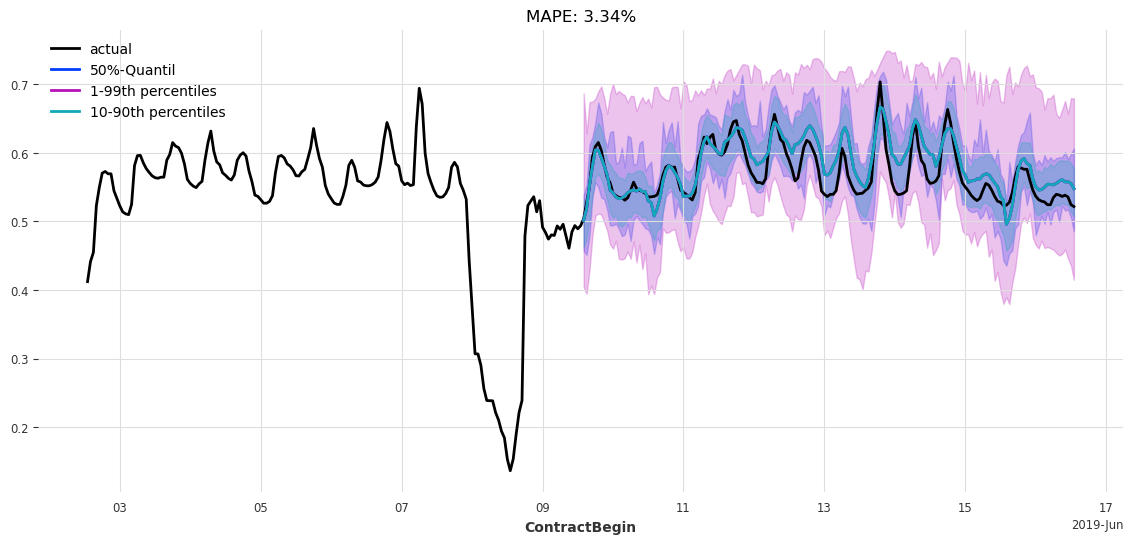

In [26]:
#Hyperparameteroptimierung

# param_grid = {
#     'hidden_size': [32, 64, 128],
#     'lstm_layers': [1, 2],
#     'num_attention_heads': [4, 8]
# }

# grid = ParameterGrid(param_grid)

# for i, params in enumerate(grid):
#     input_chunk_length = 24
#     forecast_horizon = 24
#     my_model = TFTModel(
#         input_chunk_length=input_chunk_length,
#         output_chunk_length=forecast_horizon,
#         hidden_size=params['hidden_size'],
#         lstm_layers=params['lstm_layers'],
#         num_attention_heads=params['num_attention_heads'],
#         dropout=0.4,
#         batch_size=1500,
#         n_epochs=10,
#         add_relative_index=True,
#         add_encoders=None,
#         random_state=42,
#         pl_trainer_kwargs={
#             "accelerator": "cpu"
#         },
#     )
#     my_model.fit(target_train_transformed,past_covariates=past_covariates_series_transformed, future_covariates=future_covariates_series_transformed, verbose=True)
    
#     print('hidden_size: '+ str(params['hidden_size'])+', lstm_layers: '+ str(params['lstm_layers'])+', num_attention_heads: '+str(params['num_attention_heads']))
#     eval_model(my_model, 168, target_series_transformed, target_val_transformed)

### Training des Modells

In [28]:
my_model.fit(target_train_transformed, past_covariates=past_covariates_series_transformed, future_covariates=future_covariates_series_transformed, verbose=True)

Training: |          | 0/? [00:00<?, ?it/s]

TFTModel(output_chunk_shift=0, hidden_size=128, lstm_layers=2, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.4, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=24, batch_size=1500, n_epochs=40, add_encoders=None, random_state=42, pl_trainer_kwargs={'accelerator': 'cpu'})

### Ergebnisse des besten Modells

Predicting: |          | 0/? [00:00<?, ?it/s]

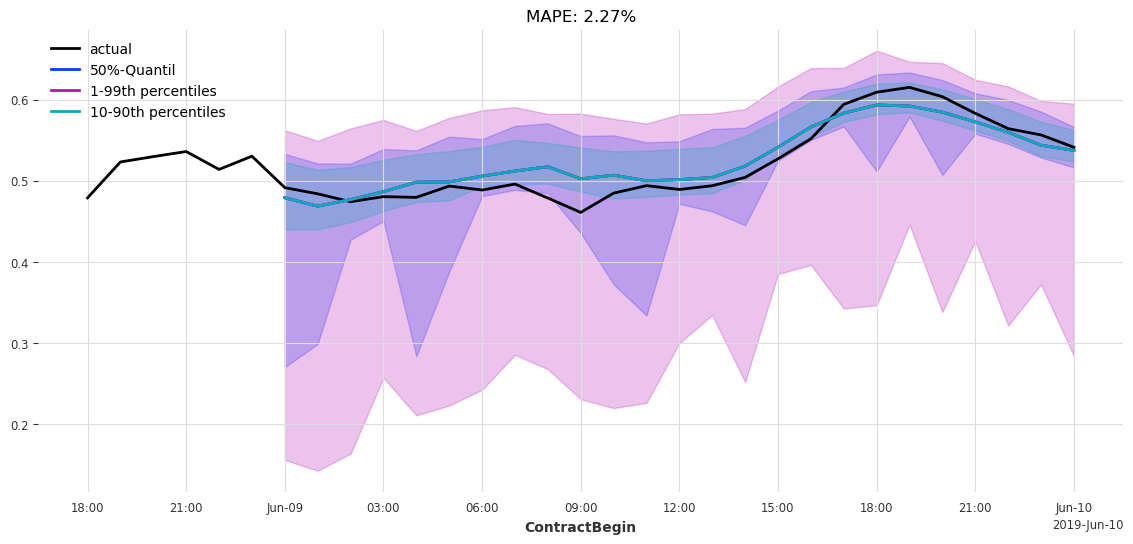

In [64]:
pred_series= eval_model(my_model, 25, target_series_transformed, target_val_transformed)

### Backtesting


In [30]:
backtest_series = my_model.historical_forecasts(
    target_series_transformed,
    future_covariates=future_covariates_series_transformed,
    past_covariates=past_covariates_series_transformed,
    start=train.end_time() + train.freq,
    num_samples=num_samples,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
)

Predicting: |          | 0/? [00:00<?, ?it/s]

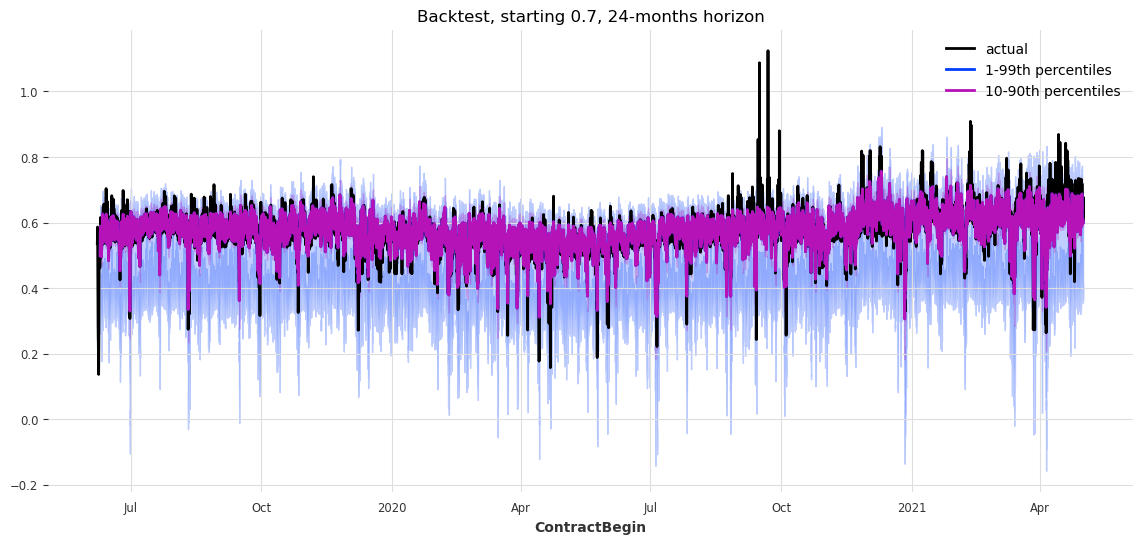

In [31]:
def eval_backtest(backtest_series, actual_series, horizon, start, transformer):
    plt.figure(figsize=figsize)
    actual_series.univariate_component(0)[backtest_series.start_time()-48*actual_series.freq: actual_series.end_time()].plot(label="actual")
    backtest_series.univariate_component(0).plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    backtest_series.univariate_component(0).plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)
    plt.legend()
    plt.title(f"Backtest, starting {start}, {horizon}-months horizon")


eval_backtest(
    backtest_series=concatenate(backtest_series),
    actual_series=target_series_transformed,
    horizon=forecast_horizon, 
    start=training_cutoff,
    transformer=target_transformer,
)